#### ClinVar Missense Pathogenicity Analysis

In [34]:
import pandas as pd
import numpy as np
import requests
import gzip
import shutil
from pathlib import Path
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Fetch and Filter Data

In [15]:
# Data source configuration
CLINVAR_URL = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz"
CLINVAR_GZ = "variant_summary.txt.gz"
CLINVAR_TXT = "variant_summary.txt"
OUTPUT_CSV = "clinvar_missense_variants.csv"

# Filtering criteria
VALID_SIGNIFICANCE = {"Pathogenic", "Likely pathogenic", "Benign", "Likely benign"}
GENOME_BUILD = "GRCh38"  # Compatible with AlphaFold, Ensembl, UniProt
CHUNK_SIZE = 100_000

# Precompiled regex patterns for efficiency
HAS_P_PROTEIN_CHANGE = re.compile(r"\(p\.", re.ASCII)
EXTRACT_PROTEIN_CHANGE = re.compile(r"\(p\.(.*?)\)", re.ASCII)
IS_MISSENSE = re.compile(r"^[A-Z][a-z]{2}\d+[A-Z][a-z]{2}$", re.ASCII)

# Columns to read (memory optimization)
READ_COLS = ["Assembly", "Type", "ClinicalSignificance", "Name", "GeneSymbol", "HGNC_ID"]

In [16]:
def download_and_extract_clinvar() -> None:
    if not Path(CLINVAR_GZ).exists():
        with requests.get(CLINVAR_URL, stream=True) as r:
            r.raise_for_status()
            with open(CLINVAR_GZ, "wb") as f_out:
                shutil.copyfileobj(r.raw, f_out)

    if not Path(CLINVAR_TXT).exists():
        with gzip.open(CLINVAR_GZ, "rb") as f_in, open(CLINVAR_TXT, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

In [17]:
def filter_chunk(chunk: pd.DataFrame) -> pd.DataFrame:
    """
    Filter ClinVar chunk for protein-coding missense SNVs with clear clinical significance, using GRCh38 coordinates.
    """
    # Initial filters for relevant vatiant type

    chunk = chunk[
        (chunk["Assembly"] == GENOME_BUILD)
        & (chunk["Type"] == "single nucleotide variant")
        & (chunk["ClinicalSignificance"].isin(VALID_SIGNIFICANCE))
        & (chunk["Name"].str.contains(HAS_P_PROTEIN_CHANGE, na=False))
    ].copy()

    # Extract protein change string
    
    chunk["protein_change"] = chunk["Name"].str.extract(EXTRACT_PROTEIN_CHANGE)

    # Keep only missense variants
    # Match: 3-letter AA, position, and new AA

    missense_mask = chunk["protein_change"].str.match(IS_MISSENSE, na=False)
    chunk = chunk[missense_mask].copy()

    return chunk[
        ["GeneSymbol", "HGNC_ID", "ClinicalSignificance", "Name", "protein_change"]
    ].rename(
        columns={"GeneSymbol": "gene"}
    )


In [18]:
def filter_missense_variants_streaming() -> None:
    reader = pd.read_csv(
        CLINVAR_TXT,
        sep="\t",
        chunksize=CHUNK_SIZE,
        low_memory=False,
        usecols=READ_COLS,
        dtype={"Assembly": "category", "Type": "category", "ClinicalSignificance": "category"},
    )

    is_first = True
    total = 0

    for chunk in reader:
        filtered = filter_chunk(chunk)
        if not filtered.empty:
            filtered.to_csv(OUTPUT_CSV, mode="w" if is_first else "a", header=is_first, index=False)
            is_first = False
            total += len(filtered)
    
    print(f"Saved {total} missense variants to {OUTPUT_CSV}.")

In [19]:
# Main execution

if __name__ == "__main__":
    download_and_extract_clinvar()
    filter_missense_variants_streaming()

Saved 239112 missense variants to clinvar_missense_variants.csv.


##### Feature Extraction

In [21]:
# Load pre-parsed ClinVar VCF
clinvar_df = pd.read_csv("clinvar_missense_variants.csv")

# Inspect
clinvar_df.head()
clinvar_df[clinvar_df['protein_change'].notna()]

,gene,HGNC_ID,ClinicalSignificance,Name,protein_change
0,FOXRED1,HGNC:26927,Pathogenic,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),Gln232Ter
1,FOXRED1,HGNC:26927,Likely pathogenic,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),Asn430Ser
2,HFE,HGNC:4886,Pathogenic,NM_000410.4(HFE):c.989G>T (p.Arg330Met),Arg330Met
3,WDR35,HGNC:29250,Pathogenic,NM_020779.4(WDR35):c.1844A>G (p.Glu615Gly),Glu615Gly
4,WDR35,HGNC:29250,Likely pathogenic,NM_020779.4(WDR35):c.2590G>A (p.Ala864Thr),Ala864Thr
...,...,...,...,...,...
239107,CUL4B,HGNC:2555,Likely pathogenic,NM_001079872.2(CUL4B):c.1051C>T (p.Arg351Ter),Arg351Ter
239108,COL4A1,HGNC:2202,Likely pathogenic,NM_001845.6(COL4A1):c.3877G>A (p.Gly1293Ser),Gly1293Ser
239109,ATRX,HGNC:886,Likely pathogenic,NM_000489.6(ATRX):c.5651C>T (p.Thr1884Ile),Thr1884Ile
239110,IRF6,HGNC:6121,Pathogenic,NM_006147.4(IRF6):c.947T>C (p.Leu316Pro),Leu316Pro


In [22]:
## Parse protein_change into components

def parse_protein_change(change):
    match = re.match(r'^([A-Z][a-z]{2})(\d+)([A-Z][a-z]{2})$', change)
    if match:
        ref, pos, alt = match.groups()
        return pd.Series([ref, int(pos), alt])
    return pd.Series([None, None, None])

clinvar_df[['aa_ref_3', 'aa_pos', 'aa_alt_3']] = clinvar_df['protein_change'].apply(parse_protein_change)

In [24]:
# Load amino acid properties from CSV files and create dictionaries
aa_3to1_df = pd.read_csv('aa_features/aa_3to1_mapping.csv')
aa_polarity_df = pd.read_csv('aa_features/aa_polarity.csv')
aa_charge_df = pd.read_csv('aa_features/aa_charge.csv')
aa_volume_df = pd.read_csv('aa_features/aa_volume.csv')

# Create lookup dictionaries from CSV data
AA3_to_1 = dict(zip(aa_3to1_df['aa_3letter'], aa_3to1_df['aa_1letter']))
aa_polarity = dict(zip(aa_polarity_df['aa_1letter'], aa_polarity_df['polarity']))
aa_charge = dict(zip(aa_charge_df['aa_1letter'], aa_charge_df['charge']))
aa_volume = dict(zip(aa_volume_df['aa_1letter'], aa_volume_df['volume']))

# Load Grantham matrix and create symmetric lookup
grantham_df = pd.read_csv('aa_features/grantham_matrix.csv')
symmetric_grantham = {}
for _, row in grantham_df.iterrows():
    symmetric_grantham[(row['aa_ref'], row['aa_alt'])] = row['grantham_score']
    symmetric_grantham[(row['aa_alt'], row['aa_ref'])] = row['grantham_score']

In [25]:
# Convert to 1-letter codes
clinvar_df['aa_ref'] = clinvar_df['aa_ref_3'].map(AA3_to_1)
clinvar_df['aa_alt'] = clinvar_df['aa_alt_3'].map(AA3_to_1)

# Drop rows with missing or invalid amino acid codes
valid_aas = set("ARNDCQEGHILKMFPSTWYV")
clinvar_df = clinvar_df[
    clinvar_df['aa_ref'].isin(valid_aas) &
    clinvar_df['aa_alt'].isin(valid_aas)
]

# Drop rows with missing position
clinvar_df = clinvar_df[clinvar_df['aa_pos'].notna()]

In [26]:
# Complete feature columns

# Grantham distance
def get_grantham(row):
    return symmetric_grantham.get((row['aa_ref'], row['aa_alt']), None)

clinvar_df['grantham'] = clinvar_df.apply(get_grantham, axis=1)

# Polarity shift
def get_polarity_change(row):
    ref = aa_polarity.get(row['aa_ref'])
    alt = aa_polarity.get(row['aa_alt'])
    return f"{ref}_to_{alt}" if ref and alt else None

clinvar_df['polarity_change'] = clinvar_df.apply(get_polarity_change, axis=1)

# Charge change

def get_charge_change(row):
    ref = aa_charge.get(row['aa_ref'])
    alt = aa_charge.get(row['aa_alt'])
    return f"{ref}_to_{alt}" if ref and alt else None

clinvar_df['charge_change'] = clinvar_df.apply(get_charge_change, axis=1)

# Volume change

def get_volume_diff(row):
    v1 = aa_volume.get(row['aa_ref'])
    v2 = aa_volume.get(row['aa_alt'])
    return abs(v2 - v1) if v1 and v2 else None

clinvar_df['volume_diff'] = clinvar_df.apply(get_volume_diff, axis=1)

In [27]:
# Convert ClinicalSignificance to binary for analysis

clinvar_df['label'] = clinvar_df['ClinicalSignificance'].map({
    'Pathogenic': 1,
    'Likely pathogenic': 1,
    'Benign': 0,
    'Likely benign': 0
})
clinvar_df = clinvar_df[clinvar_df['label'].notna()]

In [28]:
clinvar_df.to_csv("clinvar_missense_with_features.csv", index=False)

##### Visualize Features vs. Pathogenicity

In [30]:
# df = pd.read_csv("clinvar_missense_with_features.csv")
df = clinvar_df.copy()

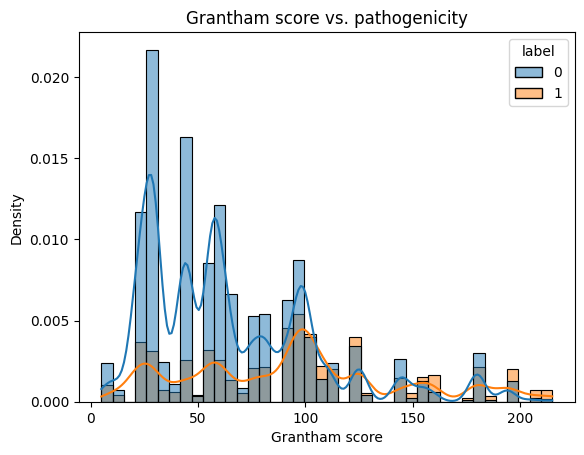

In [35]:
# Plot distribution of Grantham scores

sns.histplot(data=df, x='grantham', hue='label', bins=40, kde=True, stat="density")
plt.title("Grantham score vs. pathogenicity")
plt.xlabel("Grantham score")
plt.ylabel("Density")
plt.show();

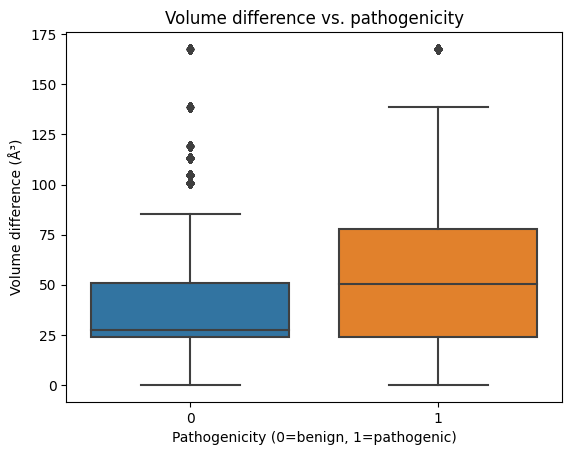

In [37]:
# Box plot of volume difference

sns.boxplot(data=df, x='label', y='volume_diff')
plt.title("Volume difference vs. pathogenicity")
plt.xlabel("Pathogenicity (0=benign, 1=pathogenic)")
plt.ylabel("Volume difference (Å³)")
plt.show()

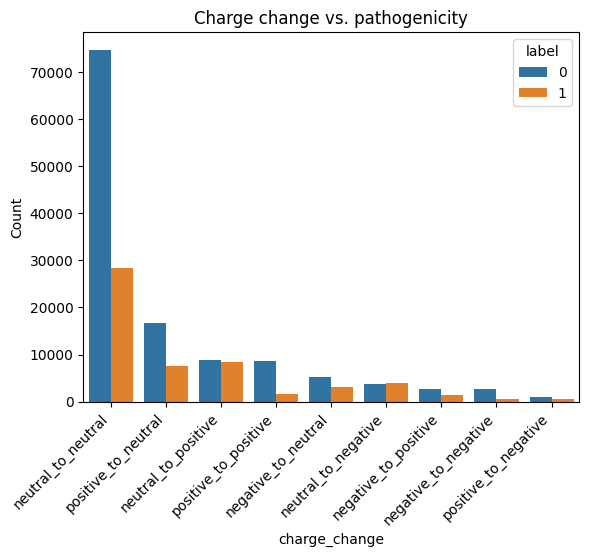

In [38]:
# Bar chart for charge changes

sns.countplot(data=df, x='charge_change', hue='label', order=df['charge_change'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title("Charge change vs. pathogenicity")
plt.ylabel("Count")
plt.show()